## Check district data

### Population per district


In [1]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-26T14:27:10.806967+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import shapely
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from shapely.ops import nearest_points, unary_union
import pyproj
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandana as pdna
import igraph as ig
import pulp

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

pandas    : 2.2.1
matplotlib: 3.8.3
networkx  : 3.2.1
pandana   : 0.7
shapely   : 2.0.3
pyproj    : 3.6.1
igraph    : 0.11.4
pulp      : 2.8.0
numpy     : 1.26.4
geopandas : 0.14.3
osmnx     : 1.9.1



In [3]:
# import all police districts from file - geojson did not work for some reason
# police_districts_gdf = gpd.read_file("../data/police_districts/Basisdata_0000_Norge_25833_PolitiSonerDistrikter_GeoJSON/Basisdata_0000_Norge_25833_PolitiSonerDistrikter_GeoJSON.geojson")
# police_districts_gdf = gpd.read_file("../data/police_districts/Basisdata_0000_Norge_25833_PolitiSonerDistrikter_GML/Basisdata_0000_Norge_25833_PolitiSonerDistrikter_GML.gml", driver='GML')
districts_gdf = gpd.read_file("../data/police_districts/Basisdata_0000_Norge_25833_PolitiSonerDistrikter_FGDB/Basisdata_0000_Norge_25833_PolitiSonerDistrikter_FGDB.gdb", driver='FileGDB', layer='PolitiDistrikt')
districts_gdf.head(2)

,objtype,lokalid,navnerom,versjonid,oppdateringsdato,datauttaksdato,geodataeier,geodataprodusent,politidistriktnavn,politidistriktnummer,SHAPE_Length,SHAPE_Area,geometry
0,Politidistrikt,87fae7b1-8dd5-4421-8aa7-a1fb0444a6d5,https://data.geonorge.no/sosi/administrativeen...,20221010,2022-09-07 00:00:00+00:00,2022-09-23 10:12:13+00:00,Politi- og lensmannsetaten,Kartverket,Sysselmesteren på Svalbard,62,194823.787,2982857059.273,"MULTIPOLYGON (((622945.587 8231320.844, 621945..."
1,Politidistrikt,a7e37bed-72ec-4751-8d5c-116f3cc29bcb,https://data.geonorge.no/sosi/administrativeen...,20221010,2022-09-07 00:00:00+00:00,2022-09-23 10:12:13+00:00,Politi- og lensmannsetaten,Kartverket,Sysselmesteren på Svalbard,62,1765995.016,132623763796.629,"MULTIPOLYGON (((642503.317 8974589.147, 643343..."


In [4]:
# Change CRS from UTM33N to WGS84
print("CRS of the districts_gdf:", districts_gdf.crs)
districts_gdf = districts_gdf.to_crs(epsg=4326)
print("CRS of the districts_gdf:", districts_gdf.crs)

CRS of the districts_gdf: EPSG:25833
CRS of the districts_gdf: EPSG:4326


In [5]:
def clean_data(police_districts_gdf):
    # Drop column: 'objtype'
    police_districts_gdf = police_districts_gdf.drop(columns=['objtype', 'navnerom', 'versjonid', 'oppdateringsdato', 'datauttaksdato', 'geodataeier', 'geodataprodusent'])
    police_districts_gdf = police_districts_gdf.rename(columns={'lokalid': 'lokalID', 'politidistriktnavn': 'districtName', 'politidistriktnummer': 'districtID'})
    
    # If districtName contains substring Svalbard in any upper/lower case combination, then delete row
    police_districts_gdf = police_districts_gdf[~police_districts_gdf['districtName'].str.contains('svalbard', case=False)]
    return police_districts_gdf

districts_clean = clean_data(districts_gdf.copy())
print("Shape of the cleaned dataset:", districts_clean.shape)
districts_clean.head(4)

Shape of the cleaned dataset: (12, 6)


,lokalID,districtName,districtID,SHAPE_Length,SHAPE_Area,geometry
5,e1762655-ad1e-4eaa-aa25-e7713bffea52,Oslo politidistrikt,201,240454.396,1233150525.719,"MULTIPOLYGON (((10.73101 59.87718, 10.71810 59..."
6,0864cb4d-a697-46ab-9a1f-ac4f802ae57f,Øst politidistrikt,202,675838.072,9817130626.535,"MULTIPOLYGON (((11.15351 59.07926, 11.12656 59..."
7,f6acc5e9-84a1-4c8f-8eb1-69d6da1ef1e8,Innlandet politidistrikt,203,1413687.019,52403856403.783,"MULTIPOLYGON (((10.77218 60.21377, 10.77231 60..."
8,d6c66ee5-09f7-46b8-a5c2-1a667c76820d,Sør-Øst politidistrikt,204,1028797.167,35223823522.815,"MULTIPOLYGON (((9.96977 58.72045, 9.78836 58.6..."


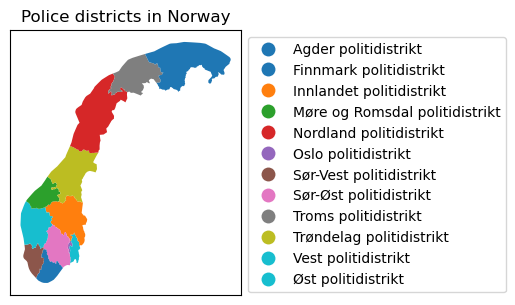

In [6]:
# plot the different districtNames
fig, ax = plt.subplots(figsize=(5, 5))
districts_clean.plot(ax=ax, column='districtName', legend=True, legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left', 'prop': {'size': 10}})
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
plt.title('Police districts in Norway')
plt.tight_layout(); plt.show()

Now we have the polygon for the Øst police district. Note that this polygon does not have any coordinate system (CRS) info, we have to add this.   
For GeoDataFrames, we simply use the `to_crs` method, while for shapely polygons we use the `pyproj` library.

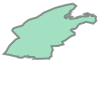

In [13]:
Agder_gdf = districts_clean[districts_clean['districtName'] == 'Agder politidistrikt']
Finnmark_gdf = districts_clean[districts_clean['districtName'] == 'Finnmark politidistrikt']
Inland_gdf = districts_clean[districts_clean['districtName'] == 'Innlandet politidistrikt']
MoreRomsdal_gdf = districts_clean[districts_clean['districtName'] == 'Møre og Romsdal politidistrikt']
Nordland_gdf = districts_clean[districts_clean['districtName'] == 'Nordland politidistrikt']
Oslo_gdf = districts_clean[districts_clean['districtName'] == 'Oslo politidistrikt']
SouthWest_gdf = districts_clean[districts_clean['districtName'] == 'Sør-Vest politidistrikt']
SouthEast_gdf = districts_clean[districts_clean['districtName'] == 'Sør-Øst politidistrikt']
Troms_gdf = districts_clean[districts_clean['districtName'] == 'Troms politidistrikt']
Trondelag_gdf = districts_clean[districts_clean['districtName'] == 'Trøndelag politidistrikt']
West_gdf = districts_clean[districts_clean['districtName'] == 'Vest politidistrikt']
East_gdf = districts_clean[districts_clean['districtName'] == 'Øst politidistrikt']
Nordland_poly = Nordland_gdf.iloc[0].geometry
Nordland_poly

### 2. Process population data

In [16]:
# Import population data for entire Norway
Norway_population_path = "../data/Norway/ssb_population/v_ru250m_2021_rutenett.geojson"
Norway_population = gpd.read_file(Norway_population_path)
Norway_population.columns = ['id', 'population', 'geometry'] # rename column names

In [17]:
# %%time
# # count the population in each police district - 2021
# districts_population = gpd.overlay(districts_clean, Norway_population, how='intersection')
# districts_population = districts_population[['districtName', 'population']].groupby('districtName').sum().reset_index()
# districts_population

CPU times: total: 4min 39s
Wall time: 5min 17s


,districtName,population
0,Agder politidistrikt,306798
1,Finnmark politidistrikt,74472
2,Innlandet politidistrikt,379374
3,Møre og Romsdal politidistrikt,265086
4,Nordland politidistrikt,239744
5,Oslo politidistrikt,919846
6,Sør-Vest politidistrikt,527346
7,Sør-Øst politidistrikt,688962
8,Troms politidistrikt,166057
9,Trøndelag politidistrikt,471667


In [15]:
# %%time
# # count the population in each police district - 2023
# districts_population = gpd.overlay(districts_clean, Norway_population, how='intersection')
# districts_population = districts_population[['districtName', 'population']].groupby('districtName').sum().reset_index()
# districts_population

CPU times: total: 3min 29s
Wall time: 4min 53s


,districtName,population
0,Agder politidistrikt,314051
1,Finnmark politidistrikt,73957
2,Innlandet politidistrikt,382847
3,Møre og Romsdal politidistrikt,268131
4,Nordland politidistrikt,240687
5,Oslo politidistrikt,937316
6,Sør-Vest politidistrikt,537847
7,Sør-Øst politidistrikt,702788
8,Troms politidistrikt,167074
9,Trøndelag politidistrikt,479379
